In [1]:
!pip install einops keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 15.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.8/751.8 kB 23.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import einops

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Create the dataset

#### read the captions txt file and make dict that has image name as its key image captions as a list

In [60]:
from collections import defaultdict
import re
import string

def clean(x):
    x = re.sub(r'{ .\n|\n|}', '', x)
    x = x.lower()
    x = re.sub(f'[{re.escape(string.punctuation)}]', '', x)
    
    return x.strip()

imgs = []
caps = []
d = defaultdict(list)

caption_path = '/kaggle/input/flickr8k/captions.txt'
image_path = '/kaggle/input/flickr8k/Images/'
with open(caption_path, 'r') as f:
    next(f)
    lines = f.readlines()

for line in lines:
    arr = line.split(',')
    d[image_path + arr[0]].append(clean(arr[1]))
    imgs.append(image_path + arr[0])
    caps.append(clean(arr[1]))

### decoding text

we will use TextVectorizer layer and create word_to_idx and idx_to_word using
StringLookup layer

In [4]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import StringLookup

max_length = max(len(x.split()) for x in caps)

def standardize_input(x):
    x = tf.strings.join(['[START]', x], separator=' ')
    
    return x

def standardize_output(x):
    x = tf.strings.join([x, '[END]'], separator=' ')
    
    return x

input_txt_vect = TextVectorization(
                output_sequence_length=max_length,
                standardize=standardize_input
            )

output_txt_vect = TextVectorization(
                output_sequence_length=max_length,
                standardize=standardize_output
            )

input_txt_vect.adapt(caps)
output_txt_vect.adapt(caps)

vocab = input_txt_vect.get_vocabulary()
print(len(input_txt_vect.get_vocabulary()))
vocab[:10]

8633


['', '[UNK]', 'a', '[START]', 'in', 'the', 'on', 'is', 'and', 'dog']

In [5]:
idx_to_wrd = {idx:wrd for idx,wrd in enumerate(vocab)}
wrd_to_idx = {wrd:idx for idx,wrd in enumerate(vocab)}

### handling images

In [6]:
IMAGE_SHAPE=(299, 299, 3)

#read image and resize it
def read_and_resize(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    
    return img

In [7]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
def make_dataset(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    def tokenize(x, y):

        return ({'encoder_inputs': read_and_resize(x), 'decoder_inputs': input_txt_vect(y)}, output_txt_vect(y))

    dataset = dataset.map(tokenize)
    return dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)
    
x_train, x_test, y_train, y_test = train_test_split(imgs, caps, test_size=.1, random_state=42)

In [8]:
train_ds = make_dataset(x_train, y_train)
test_ds = make_dataset(x_test, y_test)

for (x, z) in train_ds.take(1):
    print(x, z)

{'encoder_inputs': <tf.Tensor: shape=(32, 299, 299, 3), dtype=float32, numpy=
array([[[[9.13444824e+01, 1.45311035e+02, 1.07983276e+02],
         [8.99498291e+01, 1.40000000e+02, 1.03000000e+02],
         [8.67224121e+01, 1.42722412e+02, 1.05722412e+02],
         ...,
         [8.35554199e+01, 1.14444580e+02, 8.87640076e+01],
         [7.80916443e+01, 1.10983337e+02, 8.40000000e+01],
         [8.16969910e+01, 1.11663910e+02, 8.73360901e+01]],

        [[9.11137772e+01, 1.44668121e+02, 1.05604065e+02],
         [9.44775543e+01, 1.38730576e+02, 1.04939667e+02],
         [8.63047333e+01, 1.44211609e+02, 1.04178543e+02],
         ...,
         [7.72803650e+01, 1.18131523e+02, 9.23512039e+01],
         [8.32080154e+01, 1.11669868e+02, 8.33407059e+01],
         [8.36314926e+01, 1.14724205e+02, 8.55942993e+01]],

        [[9.29683533e+01, 1.44466431e+02, 1.08418900e+02],
         [9.23197784e+01, 1.39747299e+02, 1.04757462e+02],
         [8.86687622e+01, 1.46557175e+02, 1.07268654e+02],
     

In [9]:
max_length

33

In [10]:
#constants

vocab_size = len(vocab)
seq_len    = max_length
emb_size  = 256
num_heads = 12
key_dims = 256
units = 256
dropout_rate = .3

## Create the model

The model architecture used here is inspired by Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
The archeticture uses an CNN image encoder and transformer decoder

### Image Encoder

i will use inception net here as an image feature extractor

In [11]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model

image_model = MobileNetV3Large(include_top=False, include_preprocessing=True)
image_model.trainable = False

class ImageFeatureExtractor(Model):
    def __init__(self, image_model):
        super(ImageFeatureExtractor, self).__init__()
        
        self.model = image_model
        
    def call(self, x):
        
        return self.model(x)
    
test_img = read_and_resize(imgs[0])[None, :]
ImageFeatureExtractor(image_model)(test_img)

12683000/12683000 [==============================] - 1s 0us/step


<tf.Tensor: shape=(1, 9, 9, 960), dtype=float32, numpy=
array([[[[-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.1621286 , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         ...,
         [-0.        ,  4.8903637 , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ]],

        [[-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  4.8469477 , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  1.2914732 , -0.        , ..., -0.16611794,
          -0.        , -0.   

Decoder Model is a trasformer decoder block

## Decoder Model

#### lets make an rnn decoder

In [12]:
units = 256
num_heads = 6
key_dims = 256
emb_size = 256

In [13]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import LSTM, Dense, MultiHeadAttention, Embedding, LayerNormalization, Dropout

class DecoderLSTM(Model):
    def __init__(self, units, num_heads, key_dims, vocab_size, emb_size, dropout_rate):
        super().__init__()
        
        self.embd  = Embedding(vocab_size, emb_size, mask_zero=True)
        self.lstm = LSTM(units, return_sequences=True)
        self.drp1 = Dropout(dropout_rate)
        
        self.attn = MultiHeadAttention(num_heads, key_dims)
        self.nrm1 = LayerNormalization()
        self.dense = Dense(units, activation='relu')
        self.drp2 = Dropout(dropout_rate)
        
        self.outputs = Dense(vocab_size, activation='softmax')
        
    def call(self, x, encoder_output):
        
        x = self.embd(x)
        x = self.drp1(x)
        x = self.lstm(x)
        
        attn, attn_scores = self.attn(x, encoder_output, return_attention_scores=True)
        self.last_attention_scores = attn_scores
        
        x = x + self.nrm1(attn)
        x = self.dense(x)
        x = self.drp2(x)
        
        return self.outputs(x)

In [14]:
class CaptionMeLSTM(Model):
    def __init__(self, image_model, num_heads, key_dims, units, vocab_size, emb_size, dropout_rate=.1):
        super(CaptionMeLSTM, self).__init__()
        
        self.encoder_model = ImageFeatureExtractor(image_model)
        self.decoder_model = DecoderLSTM(units, num_heads, key_dims, vocab_size, emb_size, dropout_rate)
#         Dense(256, activatio='relu')
    def call(self, inputs):
        x, y = inputs['encoder_inputs'], inputs['decoder_inputs']
        
        enc_out = self.encoder_model(x)
        enc_out = einops.rearrange(enc_out, 'b h w c -> b (h w) c')
        
        dec_out = self.decoder_model(y, enc_out)
        
        return dec_out

In [15]:
rand_img = np.random.random((1, 299, 299, 3))/255
rand_txt = np.random.random((1, 33))/255

caption_lstm = CaptionMeLSTM(image_model, num_heads, key_dims, units, vocab_size, emb_size, dropout_rate=.3)
caption_lstm({"encoder_inputs": rand_img, "decoder_inputs": rand_txt})

<tf.Tensor: shape=(1, 33, 8633), dtype=float32, numpy=
array([[[1.19193792e-04, 1.10266541e-04, 9.84267899e-05, ...,
         1.17695228e-04, 1.22891535e-04, 1.07161221e-04],
        [1.19128148e-04, 1.10063782e-04, 9.84330036e-05, ...,
         1.17621610e-04, 1.22895552e-04, 1.07246502e-04],
        [1.19097131e-04, 1.09917099e-04, 9.84329381e-05, ...,
         1.17561132e-04, 1.22896439e-04, 1.07311374e-04],
        ...,
        [1.19194330e-04, 1.09455512e-04, 9.84729268e-05, ...,
         1.17259959e-04, 1.22879530e-04, 1.07552238e-04],
        [1.19194745e-04, 1.09455090e-04, 9.84733197e-05, ...,
         1.17259588e-04, 1.22879690e-04, 1.07552092e-04],
        [1.19195138e-04, 1.09454755e-04, 9.84736471e-05, ...,
         1.17259282e-04, 1.22879821e-04, 1.07551961e-04]]], dtype=float32)>

In [45]:
caption_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = caption_lstm.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20)

Epoch 1/20
1138/1138 [==============================] - 315s 261ms/step - loss: 1.4878 - accuracy: 0.7502 - val_loss: 1.2373 - val_accuracy: 0.7714
Epoch 2/20
1138/1138 [==============================] - 222s 195ms/step - loss: 1.1782 - accuracy: 0.7756 - val_loss: 1.1307 - val_accuracy: 0.7820
Epoch 3/20
1138/1138 [==============================] - 236s 207ms/step - loss: 1.0970 - accuracy: 0.7826 - val_loss: 1.0890 - val_accuracy: 0.7874
Epoch 4/20
1138/1138 [==============================] - 241s 212ms/step - loss: 1.0230 - accuracy: 0.7883 - val_loss: 1.0592 - val_accuracy: 0.7915
Epoch 5/20
1138/1138 [==============================] - 220s 193ms/step - loss: 0.9756 - accuracy: 0.7924 - val_loss: 1.0397 - val_accuracy: 0.7951
Epoch 6/20
1138/1138 [==============================] - 221s 194ms/step - loss: 0.9384 - accuracy: 0.7951 - val_loss: 1.0343 - val_accuracy: 0.7964
Epoch 7/20
1138/1138 [==============================] - 238s 209ms/step - loss: 0.9042 - accuracy: 0.7983 - val_

In [16]:
caption_lstm.save_weights('/kaggle/working/model_weights.h5')

In [18]:
import pickle

with open('/kaggle/working/vocab.pkl', 'wb') as f:
    pickle.dump((idx_to_wrd, wrd_to_idx), f)

# Inference

In [16]:
caption_me = caption_lstm.load_weights('/kaggle/input/weigths/model_weights.h5')

In [19]:
with open('/kaggle/working/vocab.pkl', 'rb') as f:
    idx_to_wrd, wrd_to_idx = pickle.load(f)

In [26]:
import matplotlib.pyplot as plt
import cv2
import random

def inference(idx, i):
    src = imgs[idx]
    image = cv2.imread(src)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,i)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    def caption(src):
        test_img = read_and_resize(src)[None, :]

        tokens = []
        start = '[START]'

        vect = wrd_to_idx[start]
        inputs = np.reshape(vect, (1, 1))
        for i in range(33):
            outputs = caption_lstm({"encoder_inputs":test_img, "decoder_inputs": inputs}).numpy()
            preds = outputs[:, -1, :]
            idx = tf.argmax(preds, axis=-1)[:, None]
            wrd = idx_to_wrd[idx.numpy()[0][0]]
            if wrd == '[END]' or wrd == '[START]':
                break
            print(wrd, end=" ")
            tokens.append(wrd)
            inputs = tf.concat([inputs, idx], axis=1)

        return ' '.join(tokens)

    return caption(src)

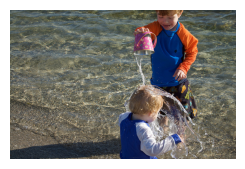

a boy in a blue shirt is holding a bucket of water 

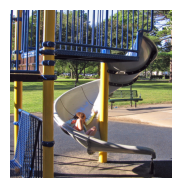

a girl is sliding down a slide at a playground 

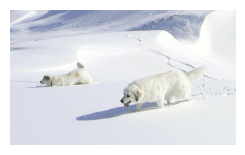

two white dogs are running through the snow 

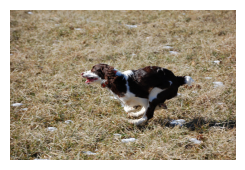

a dog runs through the grass 

In [29]:
for i in range(1, 5):
    idx = random.randint(0, 8000)
    inference(idx, i);

In [43]:
%pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


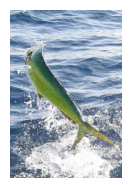

a large green fish is flying through the water 
predicted : a large green fish is flying through the water
actual : ['a green fish is jumping out of water', 'a large fish breaching the water s surface', 'a large green and blue fish leaps from the water', 'a large green fish jumps out of the water', 'the large green fish is jumping out of the water']


50.0

In [68]:
import sacrebleu

idx = random.randint(0, 8000)
tokens = inference(idx, 1)
print()
print(f'predicted : {tokens}')
print(f'actual : {d[imgs[idx]]}')

actual, predicted = list(d[imgs[idx]]), tokens
    
bleu_score = sacrebleu.corpus_bleu(predicted, [actual])
bleu_score.precisions[0]